In [8]:
import pandas as pd
import numpy as np
import json

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import label_binarize

from collections import Counter

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from scipy import interp
from itertools import cycle

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format

In [9]:
data = pd.read_csv('./CORPUS/Dataset.csv',sep=";")
data.head(8)

,description,label
0,avenue libération bp nancy cedex fax dictionna...,informatique
1,fondamentale questions étudiées informatique d...,informatique
2,permettant exprimer facilement algorithmes fac...,informatique
3,ensemble données but accéder rapidement façon ...,informatique
4,discipline universitaire mot science traductio...,informatique
5,pratique techniques méthodes organiser program...,informatique
6,ensemble objets trouver objet minimum ensemble...,informatique
7,langage généralement évolué programme généré e...,informatique


In [28]:
df_hotel = data.loc[data['label'] == 'hotel'] 
df_technologie = data.loc[data['label'] =='technologie']
df_informatique = data.loc[data['label'] == 'informatique'] 
df_science = data.loc[data['label'] =='science']


In [37]:
df_hotel = df_hotel.sample(n=1005, random_state=3, replace=True)
df_technologie = df_technologie.sample(n=805, random_state=3,  replace=True)

In [38]:
df_hotel_holdout = df_hotel.iloc[:5]
df_technologie_holdout = df_technologie.iloc[:5]
df_informatique_holdout = df_informatique.iloc[:5]
df_science_holdout = df_science.iloc[:5]

In [39]:
df_hotel = df_hotel.iloc[5:]
df_technologie = df_technologie.iloc[5:]
df_informatique = df_informatique.iloc[5:]
df_science = df_science.iloc[5:]

In [40]:
df = pd.concat([df_hotel, df_technologie, df_informatique, df_science])
df_holdout = pd.concat([df_hotel_holdout, df_technologie_holdout, df_informatique_holdout, df_science_holdout])

In [42]:
LE = LabelEncoder()
df['label_num'] = LE.fit_transform(df['label'])

display(df.groupby(['label'])['description'].count())
display(df_holdout.groupby(['label'])['description'].count())
display(df['label'].unique())
display(df['label_num'].unique())

label
hotel           1000
informatique     506
science          777
technologie      800
Name: description, dtype: int64

label
hotel           5
informatique    5
science         5
technologie     5
Name: description, dtype: int64

array(['hotel', 'technologie', 'informatique', 'science'], dtype=object)

array([0, 3, 1, 2])

In [44]:
df.head(10)

,description,label,label_num
2284,personnalisé retrouvez ambiance décontractée p...,hotel,0
2259,illimité connexion fil haut bienvenus déguster...,hotel,0
2365,var get obj var get obj var hotelid submitbook...,hotel,0
2198,rue hoche sud direction paris nantes puis dire...,hotel,0
2335,top départ expérience culture nature prix séjo...,hotel,0
2119,restaurant ainsi bar découvrez piscine salle f...,hotel,0
2177,logés chambre double frais gestion assurance a...,hotel,0
2274,confort tranquillité hauteur capitale mondiale...,hotel,0
2013,conseils visites faire ville versailles recher...,hotel,0
2368,communication neutre but avantager candidat él...,hotel,0


In [46]:
texts = df['description'].astype('str')

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), 
                                   min_df = 2, 
                                   max_df = .95)

X = tfidf_vectorizer.fit_transform(texts) #features
y = df['label_num'].values #target

print (X.shape)
print(y.shape)

(3083, 89525)
(3083,)


In [47]:
Réduction de la dimensionnalité. Utiliser uniquement les 100 meilleures fonctionnalités de la catégorie er
lsa = TruncatedSVD(n_components=100, 
                   n_iter=10, 
                   random_state=3)

X = lsa.fit_transform(X)
X.shape

(3083, 100)

In [48]:
model_dict = {'Dummy' : DummyClassifier(random_state=3),
              'Stochastic Gradient Descent' : SGDClassifier(random_state=3, loss='log'),
              'Random Forest': RandomForestClassifier(random_state=3),
              'Decsision Tree': DecisionTreeClassifier(random_state=3),
              'AdaBoost': AdaBoostClassifier(random_state=3),
              'Gaussian Naive Bayes': GaussianNB(),
              'K Nearest Neighbor': KNeighborsClassifier()}

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .3, 
                                                    shuffle = True, 
                                                    stratify = y, 
                                                    random_state = 3)

def model_score_df(model_dict):   
    model_name, ac_score_list, p_score_list, r_score_list, f1_score_list = [], [], [], [], []
    for k,v in model_dict.items():   
        model_name.append(k)
        v.fit(X_train, y_train)
        y_pred = v.predict(X_test)
        ac_score_list.append(accuracy_score(y_test, y_pred))
        p_score_list.append(precision_score(y_test, y_pred, average='macro'))
        r_score_list.append(recall_score(y_test, y_pred, average='macro'))
        f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
        model_comparison_df = pd.DataFrame([model_name, ac_score_list, p_score_list, r_score_list, f1_score_list]).T
        model_comparison_df.columns = ['model_name', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
        model_comparison_df = model_comparison_df.sort_values(by='f1_score', ascending=False)
    return model_comparison_df

model_score_df(model_dict)

,model_name,accuracy_score,precision_score,recall_score,f1_score
1,Stochastic Gradient Descent,0.94,0.94,0.93,0.93
2,Random Forest,0.94,0.93,0.93,0.93
6,K Nearest Neighbor,0.94,0.93,0.93,0.93
3,Decsision Tree,0.90,0.89,0.89,0.89
4,AdaBoost,0.88,0.88,0.87,0.87
5,Gaussian Naive Bayes,0.60,0.69,0.63,0.59
0,Dummy,0.26,0.25,0.25,0.25


In [49]:
#Hyperparameter
loss =  ['log']
penalty = ['l2','l1']
alpha = [1e-6, 1e-3, 1e-1, 1e0]
max_iter = [5, 1000, 10000]
tol = [None, 1e-3]
eta0 = [0.1, 0.001]


random_state = [3]
clf = SGDClassifier()
params = dict(loss=loss, penalty=penalty, alpha=alpha, max_iter=max_iter, tol=tol, random_state=random_state)
gridsearch = GridSearchCV(clf, params, cv = 5, verbose = 1,  n_jobs = -1)

sgd_best_model = gridsearch.fit(X, y)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 16.6min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed: 25.0min finished


In [50]:
#RF
bootstrap = [True, False]
max_depth = [10, 50, 100, None]
max_features = ['auto', 'sqrt']
min_samples_leaf = [1, 2, 4]
min_samples_split = [2, 5, 10]
n_estimators = [800, 1400, 2000]
random_state = [3]

clf = RandomForestClassifier()

params = dict(bootstrap = bootstrap,
              max_depth = max_depth,
              max_features = max_features,
              min_samples_leaf = min_samples_leaf,
              n_estimators = n_estimators,
              random_state=random_state)

gridsearch = GridSearchCV(clf, params, cv=5, verbose=1, n_jobs=-1)

rf_best_model = gridsearch.fit(X, y)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 26.2min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 66.4min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed: 122.7min finished


In [51]:
# Définir les meilleurs modèles avec les paramètres sélectionnés dans grdsearch et RandomForest
sgd_best_model = SGDClassifier(alpha=1e-06,
                               loss='log',
                               max_iter=1000,
                               penalty='l2',
                               learning_rate = 'constant',
                               eta0 = .1,
                               random_state = 3,
                               tol=None)

rf_best_model = RandomForestClassifier(bootstrap = False,
                                       max_depth = 50,
                                       max_features = 'auto',
                                       min_samples_leaf = 1,
                                       n_estimators = 1400,
                                       random_state=3)

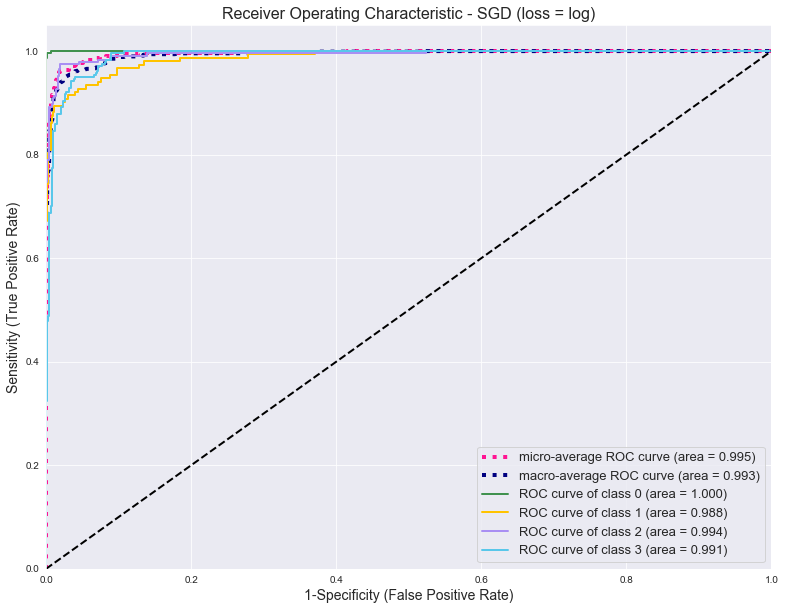

In [52]:
#Plot AUC - SGD

y_b = label_binarize(y, classes = [0, 1, 2, 3])
n_classes = y_b.shape[1]

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X,
                                                            y_b,
                                                            test_size = .3,
                                                            shuffle = True,
                                                            stratify = y,
                                                            random_state = 3)


sgd_classifier = OneVsRestClassifier(sgd_best_model)

y_score = sgd_classifier.fit(X_train_b, y_train_b).predict_proba(X_test_b)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_b[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr['micro'], tpr['micro'], _ = roc_curve(y_test_b.ravel(), y_score.ravel())
roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr
roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])

plt.figure(figsize=(13,10)) 
sns.set_style('darkgrid')
lw=2

plt.plot(fpr['micro'], 
         tpr['micro'], 
         label='micro-average ROC curve (area = {0:0.3f})'''.format(roc_auc['micro']),
         color='deeppink',
         linestyle=':', 
         linewidth=4)

plt.plot(fpr['macro'], 
         tpr['macro'], 
         label='macro-average ROC curve (area = {0:0.3f})'''.format(roc_auc['macro']),
         color='navy', 
         linestyle=':', 
         linewidth=4)

colors = cycle(['#41924F', '#FFC300', '#a98ff3', '#59C7EA'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], 
             color=color, 
             lw=lw, 
             label='ROC curve of class {0} (area = {1:0.3f})'''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity (False Positive Rate)', fontsize = 14)
plt.ylabel('Sensitivity (True Positive Rate)', fontsize = 14)
plt.title('Receiver Operating Characteristic - SGD (loss = log)', fontsize = 16)
plt.legend(loc="lower right", fontsize = 13)
plt.show()
